<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/nbs/train_pascal_2007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# what GPU do we have
!nvidia-smi

Fri Aug 28 05:58:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [4]:
# # GitHub repo sync & install the dependencies
%%bash
git clone https://github.com/benihime91/pytorch_retinanet.git
echo ">> Repo Cloned"

pip install -U pytorch-lightning --quiet 
pip install -U git+https://github.com/albumentations-team/albumentations --quiet
echo ">> Libraries successfully installed ! Proceed !!!"

tar xf /content/drive/My\ Drive/Data/VOCtrainval_06-Nov-2007.tar -C /content/ 
echo ">> Data Unziped"

>> Repo Cloned
>> Libraries successfully installed ! Proceed !!!
>> Data Unziped


Cloning into 'pytorch_retinanet'...
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.


In [3]:
import warnings
import os

# Directory Paths
annot_dir = '/content/VOCdevkit/VOC2007/Annotations'
image_dir = '/content/VOCdevkit/VOC2007/JPEGImages'

%load_ext autoreload
%autoreload 2
%matplotlib inline

os.chdir('/content/pytorch_retinanet')
warnings.filterwarnings("ignore")

In [7]:
# get recent changes
! git pull

remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 44 (delta 23), reused 28 (delta 12), pack-reused 0
Unpacking objects: 100% (44/44), done.
From https://github.com/benihime91/pytorch_retinanet
   2acb61a..a7a3276  master     -> origin/master
Updating 2acb61a..a7a3276
Fast-forward
 README.md                              | 21 +++++++++++----------
 config/augmentation/transforms.yaml    | 24 +++++++-----------------
 config/config.yaml                     |  2 ++
 config/optimizer/adam.yaml             |  4 ++++
 config/optimizer/adamW.yaml            |  5 +++++
 config/optimizer/sgd.yaml              |  6 ++++++
 config/scheduler/multi_step.yaml       |  5 +++++
 config/scheduler/reduce_on_plateu.yaml |  6 ++++++
 config/scheduler/step_lr.yaml          |  5 +++++
 src/utils/general_utils/visualizer.py  |  2 +-
 10 files changed, 52 insertions(+), 28 deletions(-)
 create mode 100644 config/o

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2

from albumentations.pytorch import ToTensorV2
import albumentations as A

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from src.models import Retinanet
from src.utils.eval_utils.coco_eval import CocoEvaluator
from src.utils.eval_utils.coco_utils import get_coco_api_from_dataset
from src.utils.general_utils import xml_to_csv
from src.utils.general_utils import Visualizer
from src.utils.general_utils.utilities import collate_fn

pl.seed_everything(42)
pd.set_option('display.max_colwidth', None)

## Preprare the Data:

Use the script `xml_to_csv` to convert the `Pascal XML Annotations` into `csv` format so that data loading becomes easier.

In [6]:
# Prepare the Data
df = xml_to_csv(annot_dir)
df['filename'] = [os.path.join(image_dir, i) for i in df.filename.values]

le = LabelEncoder()
int_cls = le.fit(df['class'].unique())
df['labels'] = le.transform(df['class'])

df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/VOCdevkit/VOC2007/JPEGImages/002179.jpg,500,375,pottedplant,6,8,487,373,15
1,/content/VOCdevkit/VOC2007/JPEGImages/002266.jpg,500,373,aeroplane,231,251,458,346,0
2,/content/VOCdevkit/VOC2007/JPEGImages/002266.jpg,500,373,aeroplane,5,118,499,258,0
3,/content/VOCdevkit/VOC2007/JPEGImages/008550.jpg,500,375,car,55,107,377,324,6
4,/content/VOCdevkit/VOC2007/JPEGImages/008550.jpg,500,375,car,371,40,459,119,6


In [9]:
names = list(df.labels.unique())
names.sort()
# Create the label dictionary
label_dict = {idx:clas for idx, clas in zip(names, list(le.inverse_transform(names)))}

# Instantiate the visualizer
viz = Visualizer(class_names=label_dict)

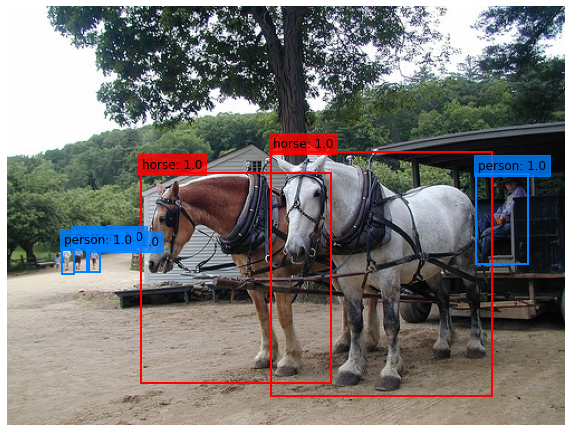

In [10]:
n = 8422  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin', 'ymin', 'xmax', 'ymax']].values
labels = df.loc[df['filename'] == fname]['labels'].values
viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

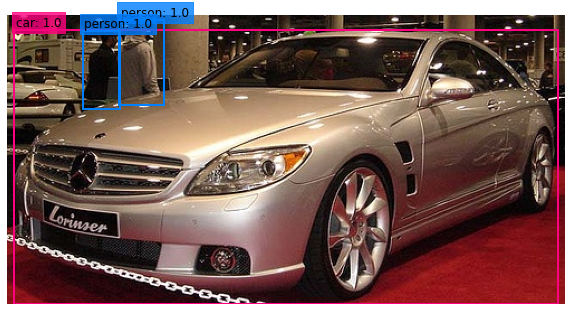

In [11]:
n = 15120  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin', 'ymin', 'xmax', 'ymax']].values
labels = df.loc[df['filename'] == fname]['labels'].values
viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

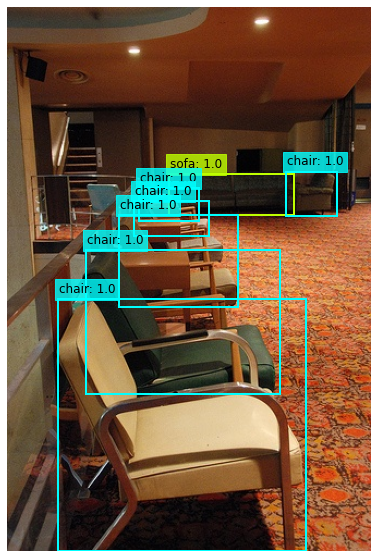

In [12]:
n = 353  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin', 'ymin', 'xmax', 'ymax']].values
labels = df.loc[df['filename'] == fname]['labels'].values
viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

In [13]:
# -------------------------------------------------- #
# Grab the Unique Image Idxs from the Filename
# -------------------------------------------------- #
unique_ids = list(df.filename.unique())

# --------------------------------------------------------- #
# Split the Unique Image Idxs into Train & valid Datasets
# --------------------------------------------------------- #
test_ids, val_ids = train_test_split(unique_ids, shuffle=True, random_state=42, test_size=0.15)

# -------------------------------------------------- #
# Create Splits on the DataFrame
# -------------------------------------------------- #
df["split"] = 0

for i,idx in enumerate(df.filename.values):
    if idx in set(test_ids)  : 
        df["split"][i] = "train"
    elif idx in set(val_ids) : 
        df["split"][i] = "val"

# -------------------------------------------------- #
# Split the DataFrame into Train and Test DataFrames
# -------------------------------------------------- #
df_trn, df_val = df.loc[df["split"] == "train"], df.loc[df["split"] == "val"]

df_trn, df_val = df_trn.reset_index(drop=True),df_val.reset_index(drop=True)

# -------------------------------------------------- #
# Save the DataFrames
# -------------------------------------------------- #
df_trn.to_csv('/content/drive/My Drive/Data/PascalVocTrain.csv',
              index=False)
df_val.to_csv('/content/drive/My Drive/Data/PascalVocValid.csv',
              index=False)

In [14]:
df_train = pd.read_csv('/content/drive/My Drive/Data/PascalVocTrain.csv')
df_train.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,labels,split
0,/content/VOCdevkit/VOC2007/JPEGImages/002179.jpg,500,375,pottedplant,6,8,487,373,15,train
1,/content/VOCdevkit/VOC2007/JPEGImages/002266.jpg,500,373,aeroplane,231,251,458,346,0,train
2,/content/VOCdevkit/VOC2007/JPEGImages/002266.jpg,500,373,aeroplane,5,118,499,258,0,train


In [15]:
df_val = pd.read_csv('/content/drive/My Drive/Data/PascalVocValid.csv')
df_val.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,labels,split
0,/content/VOCdevkit/VOC2007/JPEGImages/006166.jpg,500,419,train,125,122,312,340,18,val
1,/content/VOCdevkit/VOC2007/JPEGImages/009458.jpg,473,500,bottle,2,20,111,98,4,val
2,/content/VOCdevkit/VOC2007/JPEGImages/009458.jpg,473,500,bottle,113,13,202,110,4,val


## Instantiate Transformations:

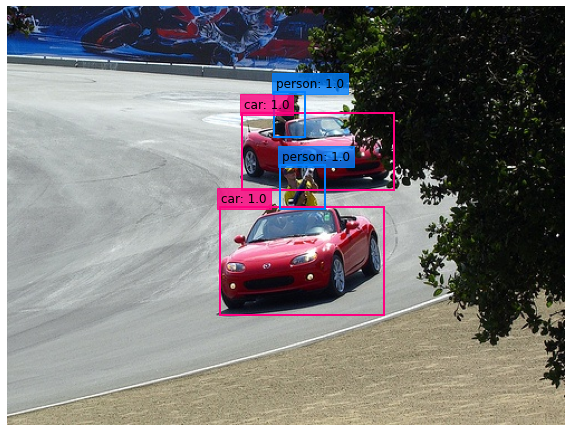

In [26]:
# @title Original Image {run:"auto", vertical-output:true, display-mode:"form"}
# -------------------------------------------------- #
# Grab and Display a Random Image
# -------------------------------------------------- #
n = 5243  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin',
                                         'ymin',
                                         'xmax',
                                         'ymax']].values
                                         
labels = df.loc[df['filename'] == fname]['labels'].values

viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

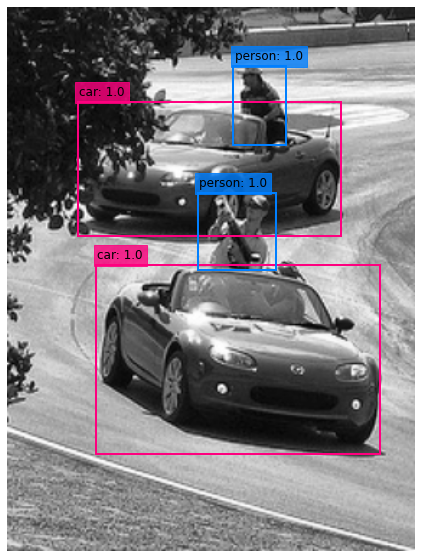

In [27]:
# @title Transformed Image: { run: "auto", vertical-output: true, display-mode: "form" }

# -------------------------------------------------- #
# Apply augmentations on the Grabbed Image
# -------------------------------------------------- #

alpha = 2.4  # @param {type:"slider", min:0, max:5, step:0.1}
width = 448  # @param {type:'integer'}
height = 336  # @param {type:'integer'}
erosion_rate = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}
to_gray = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}


tfms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.CLAHE(),
        A.OneOf([A.HueSaturationValue(), A.RandomBrightnessContrast(),]),
        A.ToGray(p=to_gray),
        A.RandomSizedBBoxSafeCrop(width, height, erosion_rate=erosion_rate, p=0.2),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
)


fname = df["filename"][n]
im = cv2.cvtColor(cv2.imread(df["filename"][n]), cv2.COLOR_BGR2RGB)
boxes = df.loc[df["filename"] == fname][["xmin", "ymin", "xmax", "ymax"]].values
labels = df.loc[df["filename"] == fname]["labels"].values

transformed = tfms(image=im, bboxes=boxes, class_labels=labels)

image = transformed["image"]
boxes = transformed["bboxes"]
labels = transformed["class_labels"]

viz.draw_bboxes(image, boxes=boxes, classes=labels, figsize=(10, 10))

In [17]:
# -------------------------------------------------- #
# Train Transformations :
# -------------------------------------------------- #
train_transformations = [
    A.HorizontalFlip(p=0.5),
    A.CLAHE(),
    A.OneOf([
ß        A.HueSaturationValue(),
        A.RandomBrightnessContrast(), 
    ]),
    A.ToGray(p=0.2),
    A.RandomSizedBBoxSafeCrop(width=448, height=336, erosion_rate=0.2, p=0.2),
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),
]

# -------------------------------------------------- #
# Valid Transformations :
# -------------------------------------------------- #
valid_transformations = [A.ToFloat(max_value=255.0, always_apply=True), ToTensorV2(always_apply=True)]

# -------------------------------------------------- #
# Transformations :
# -------------------------------------------------- #
transforms = {
    "train": A.Compose(train_transformations, p=1.0, 
                       bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"])),
    "valid": A.Compose(valid_transformations,p=1.0,
                       bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))
    }

## Create `torch.utils.data.Dataset` class:

In [18]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, train):
        
        self.df = dataframe
        
        self.image_ids = self.df["filename"]
        
        if train:
            self.tfms = transforms["train"]
        else:
            self.tfms = transforms["valid"]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # -------------------------------------------------- #
        # Grab the Image
        # -------------------------------------------------- #
        image_id = self.image_ids[idx]
        im = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)

        # -------------------------------------------------- #
        # extract the bounding boxes
        # -------------------------------------------------- #
        records = self.df[self.df["filename"] == image_id]
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        
        # -------------------------------------------------- #
        # claculate area
        # -------------------------------------------------- #
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # -------------------------------------------------- #
        # Grab the Class Labels
        # -------------------------------------------------- #
        class_labels = records["labels"].values.tolist()
        
        # -------------------------------------------------- #
        # suppose all instances are not crowd
        # -------------------------------------------------- #
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        # -------------------------------------------------- #
        # apply transformations
        # -------------------------------------------------- #
        transformed = self.tfms(image=im, bboxes=boxes, class_labels=class_labels)
        image = transformed["image"]
        boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
        class_labels = torch.tensor(transformed["class_labels"])
        
        # -------------------------------------------------- #
        # target dictionary
        # -------------------------------------------------- #
        target = {}
        image_idx = torch.tensor([idx])

        target["image_id"] = image_idx
        target["boxes"]    = boxes
        target["labels"]   = class_labels
        target["area"]     = area
        target["iscrowd"]  = iscrowd
        
        return image, target, image_idx

## Create `pl.LightningModule`:

In [19]:
class PascalModel(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        train_dl: torch.utils.data.DataLoader,
        val_dl: torch.utils.data.DataLoader,
        learning_rate: float,
        num_epochs: int,
    ):

        super(PascalModel, self).__init__()
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

    def train_dataloader(self, *args, **kwargs):
        return self.train_dl

    def val_dataloader(self, *args, **kwargs):
        valid_loader = self.val_dl

        # -------------------------------------------------- #
        # Prepare COCO Evaluator
        # -------------------------------------------------- #
        coco = get_coco_api_from_dataset(valid_loader.dataset)
        iou_types = ["bbox"]
        self.coco_evaluator = CocoEvaluator(coco, iou_types)

        return valid_loader

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def configure_optimizers(self, *args, **kwargs):
        # -------------------------------------------------- #
        # Grab trainable model Parameters
        # -------------------------------------------------- #
        params = [p for p in self.model.parameters() if p.requires_grad]

        # -------------------------------------------------- #
        # Instantiate Optimizer
        # -------------------------------------------------- #
        self.optimizer = optim.AdamW(
            params, lr=(self.learning_rate or self.lr), weight_decay=1e-02,
        )

        # -------------------------------------------------- #
        # Instantiate Scheduler
        # -------------------------------------------------- #
        self.scheduler = {
            "scheduler": (
                torch.optim.lr_scheduler.OneCycleLR(
                    optimizer=self.optimizer,
                    max_lr=(self.learning_rate or self.lr),
                    steps_per_epoch=len(self.train_dl),
                    epochs=self.num_epochs,
                )
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [self.optimizer], [self.scheduler]

    def training_step(self, batch, batch_idx, *args, **kwargs):
        # -------------------------------------------------- #
        # Traininng Step
        # -------------------------------------------------- #
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        # Separate Losses
        loss_dict = self.model(images, targets)
        # Total Loss
        losses = sum(loss for loss in loss_dict.values())
        # add learning rate to the progress bar logs
        loss_dict["lr"] = self.optimizer.param_groups[0]["lr"]

        return {"loss": losses, "log": loss_dict, "progress_bar": loss_dict}

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        # -------------------------------------------------- #
        # Validation Step
        # -------------------------------------------------- #
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {
            target["image_id"].item(): output
            for target, output in zip(targets, outputs)
        }
        self.coco_evaluator.update(res)

        return {}

    def validation_epoch_end(self, outputs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()
        # -------------------------------------------------- #
        # coco main metric
        # -------------------------------------------------- #
        metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        tensorboard_logs = {"bbox_iou": metric}

        return {
            "val_loss": metric,
            "log": tensorboard_logs,
            "progress_bar": tensorboard_logs,
        }

## Configs:

In [20]:
# -------------------------------------------------- #
#@title Configs :
# -------------------------------------------------- #

TRAIN_BATCH_SIZE = 4 #@param {type: "slider", min: 2, max: 32}
VALID_BATCH_SIZE = 20 #@param {type: "slider", min: 5, max: 32}

LR = 1e-03/5
NUM_CLASSES = 20 # PascalVoc 2007 has 20 disctinct classes


## Train `model`:

In [21]:
# -------------------------------------------------- #
# Load RetinaNet Model with resnet50 backbone 
# pretrained on Image net Dataset
# -------------------------------------------------- #
model = Retinanet(
    num_classes=NUM_CLASSES, backbone_kind="resnet50", pretrained=True, freeze_bn=True
)

# -------------------------------------------------- #
# DataLoaders
# -------------------------------------------------- #
train_dl = DataLoader(
    PascalDataset(df_train, train=True),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_dl = DataLoader(
    PascalDataset(df_val, train=False),
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

# ----------------------------------------------------------------- #
# Instantiate vanilla `Trainer` & `Ligntning model` for `lr_finder`
# ----------------------------------------------------------------- #
model = PascalModel(model, train_dl, val_dl, learning_rate=LR, num_epochs=EPOCHS)
trainer = pl.Trainer(num_sanity_val_steps=0, precision=16, gpus=1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.



  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 36 M  


creating index...
index created!


Saving latest checkpoint..


LR finder stopped early due to diverging loss.


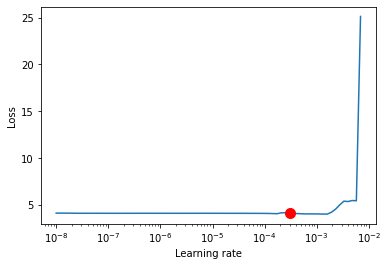

In [ ]:
# ----------------------------------------------------------------- #
# `lr_finder`
# ----------------------------------------------------------------- #
lr_finder = trainer.lr_find(model)
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
# # install wandb - weight's & biases
# %%bash
# pip install --upgrade wandb
# wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63

In [22]:
# ----------------------------------------------------------------- #
# Instantiate Trainer Loggers
# ----------------------------------------------------------------- #

# TensorBoard Logger
tb_logger = TensorBoardLogger(save_dir="/content/logs")


# Wandb logger
wb_logger = pl.loggers.WandbLogger(
    name='AdamW-one_cycle-5e-03-#20-epochs', 
    project="pascal2007-lightning"
)

# ----------------------------------------------------------------- #
# Instantiate Trainer Callbacks
# ----------------------------------------------------------------- #
save_dir = "/content/drive/My Drive/checkpoints/pacalvoc2007/"
checkpoint_callback = ModelCheckpoint(
    save_dir, mode="max", monitor="bbox_iou", save_top_k=-1
)

early_stopping_callback = EarlyStopping(
    mode="max", monitor="bbox_iou", patience=10
)

# ----------------------------------------------------------------- #
# Epochs 
# ----------------------------------------------------------------- #
EPOCHS = 20 #@param {type: "slider", min: 0, max: 500, step: 10}


# ----------------------------------------------------------------- #
# Re-Instantiate Trainer with Callbacks & Loggers
# ----------------------------------------------------------------- #
trainer = pl.Trainer(
    logger=[tb_logger, wb_logger],
    num_sanity_val_steps=0,
    early_stop_callback=early_stopping_callback,
    checkpoint_callback=checkpoint_callback,
    max_epochs=EPOCHS,
    terminate_on_nan=True,
    check_val_every_n_epoch=3,
    precision=16,
    gradient_clip_val=0.1,
    gpus=1,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [ ]:
# ----------------------------------------------------------------- #
# Set new lr
# ----------------------------------------------------------------- #
new_lr = 5e-03
model.hparams.lr = new_lr


# ----------------------------------------------------------------- #
# Train the Model with Lightning Trainer
# ----------------------------------------------------------------- #
trainer.fit(model)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 36 M  


creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=med

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=med

Saving latest checkpoint..


KeyboardInterrupt: ignored

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7fc43a11e048> (for post_run_cell):


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/pascal_voc_2007.pth')

In [ ]:
# ----------------------------------------------------------------- #
# TensorBoard Logs
# ----------------------------------------------------------------- #
import tensorboard
%load_ext tensorboard
%tensorboard --logdir='/content/logs/'